#Análisis de sentimiento de tweets sobre la vacuna COVID 19: Caso Perú 2021.

De forma general, el proyecto tiene como objetivo hacer una clasificación utilizando como medio de procesamiento algoritmos de lenguaje natural de tuits en el país de Perú para analizar el sentimiento relacionado con respecto a la vacuna COVID 19 en el año 2021. Se busca crear primeramente (con la ayuda de una API de twiter) un dataset limpio que pueda ser usado de base para entrenar un modelo de aprendizaje de máquina capaz de clasificar el sentimiento (dicho ésto sea en el contexto del lenguaje natural) de tuits respecto a la vacuna COVID19, que puede ser en contra, neutro a favor. Para lograr dicho objetivo se tienen que tokenizar los tuits y realizar el análisis de sentimiento a los mismos para tener un dataset optimo para modelos de clasificación como Regresión Logística, SVM, Random forest Classifier, NB y Gradient Boosting. Posteriormente se busca evaluar el rendimiento del modelo y poder exportar el mejor de los entrenados y así tener una implementación que a partir de tuits de entrada evaluar el sentimiento predominante en los tuits. A continuación se pueden observar los objetivos o bien, pasos a seguir a lo largo de la libreta.

---

⚠️**Importante**⚠️ si se quiere correr ésta libreta, solo hay que cambiar los path al DRIVE personal donde estén los datos o el modelo preentrenado por ejemplo.


### Importamos librerías necesarias y el modulo de drive.

In [ ]:
%%capture
!pip install geocoder                         # Microsoft Bing para obtener lugar del tuit
!pip install snscrape
import tweepy                                 # API de Twietter
from tweepy import OAuthHandler
from textblob import TextBlob                 # Traducir y Análisis de sentimientos
import textblob.exceptions
import geocoder
#import random
import time
import json                                   # Formato para almacenar los resultados
import re                                     # Regular expressions para limpieza de tuits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import snscrape.modules.twitter as sntwitter

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import gensim
from gensim.models import Word2Vec
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from google.colab import files
import pickle


# Montar drive
from google.colab import drive
drive.mount('/content/gdrive/')

### Utils

Funciones propias necesarias para ejecutar el código

In [ ]:
def clean_tweet(tweet_text):
  # Replace NON-ASCII with space
  #cleaned_text = tweet_text#''.join([i if ord(i) < 128 else '' for i in tweet_text])

  temp = tweet_text.lower()  # Convertir a minusculas
  #temp = temp.replace('/n','')
  #temp = re.sub("/n","", temp)
  temp = re.sub("@[A-Za-z0-9_]+","", temp)  # Eliminar si se etiqueto a alguien (e.g.,  se elimina @usuario_123)
  temp = re.sub("#[A-Za-z0-9_]+","", temp)  # Eliminar hashtags
  temp = re.sub(r"http\S+", "", temp)  # Eliminar "http" y todo lo que este después de esto, excepto si hay espacios entre http y el texto
  # (e.g., "https://twitter.com" se elimina, pero "http s://twitter.com" no se elimina)
  temp = re.sub(r"http", "", temp)  # Eliminar la palabra "http"
  temp = re.sub(r"www.\S+", "", temp)  # Eliminar "www." y todo lo que este después de esto, excepto si hay espacios entre www. y el texto
  # (e.g., "www.twitter.com" se elimina, pero "www. twitter.com" no se elimina)
  temp = re.sub(r"rt : ", "", temp)  # Eliminar la parte de "rt : " del texto
  temp = re.sub(r"&", "", temp)  # Eliminar los "&" del tweet porque crean un error al traducir
  temp = temp.rstrip('\n')  # Remover salto de linea al final

  return temp

def translate_tweet(tweet):
  txt=""
  for word in tweet.split():
      try:
          w=TextBlob(word)
          w=str(w.translate(from_lang= "es", to='en'))
      except textblob.exceptions.NotTranslated:
          txt=txt+word+" "
      else:
          txt=txt+w+" "
  return txt

def analizar_sentimiento(tweet):
  tweet = translate_tweet(tweet)

  analisis = TextBlob(tweet)
  if analisis.sentiment.polarity > 0:  # A favor
    return 1
  elif analisis.sentiment.polarity == 0:  # Neutro
    return 0
  else:  # En contra
    return -1


# Creación del Dataset  🐤

 ⚠️ Por cuestiones de confidencialidad se ha omitido la extracción de los tweets. Sin embargo, se hizo con la API de twiter. Se extrajeron 5000 con intervalo de fechas de enero a diciembre de 2021, se hizo mla limpieza de menciones y caracteres raros y se guardó un dataframe llamado "data" ⚠️

# Limpieza y preparación de datos 🧹

Tenmos ya nuestro dataframe "data" con los valores de los tuits en bruto, por lo que antes de pasar de texto a valores numericos en la tokenización hay que hacer una limpieza de los datos, quitando valores vacios y menciones y los tuits duplicados

In [ ]:
 # Eliminar tweets limpios que quedaron vacios (solo contienen menciones)
# Se convierten en valores nan los tweets que esten vacios
data["Tweet limpio"] = data["Tweet limpio"].str.strip().apply(lambda x: np.nan if len(x)==0 else x)
data = data[data['Tweet limpio'].notna()]

In [ ]:
#ELiminamos los tuits duplicados
print(len(data["Tweet"]))
data.drop_duplicates(subset='Tweet limpio',keep = 'last',inplace=True)
print(len(data["Tweet"]))
data.reset_index(drop=True, inplace=True)
data.head(10)

4997
4739


,Tweet,Tweet limpio,len,ID,Fecha,Fuente,Likes,RTs
0,"Fuman porro, se eskavian, toman pasti y merca ...","fuman porro, se eskavian, toman pasti y merca ...",95,1476704300470472718,2021-12-30 23:58:35+00:00,None,1,0
1,"Gabriela Jiménez, directora de Inmunizaciones,...","gabriela jiménez, directora de inmunizaciones,...",298,1476704238927495181,2021-12-30 23:58:21+00:00,None,0,0
2,Congresista Alejandro Soto revela haber dado p...,congresista alejandro soto revela haber dado p...,247,1476704032139976706,2021-12-30 23:57:31+00:00,None,8,5
3,"Tres vacunas de covid, de la gripe, de neumoco...","tres vacunas de covid, de la gripe, de neumoco...",170,1476703986069692416,2021-12-30 23:57:20+00:00,None,1,0
4,@mariobryceofic Lo ideal hubiera sido que ante...,lo ideal hubiera sido que antes de cualquier v...,223,1476703839327772674,2021-12-30 23:56:45+00:00,None,0,0
5,@pastordc3110 Me gustaría ver un debate con da...,me gustaría ver un debate con dato entre este ...,282,1476703547689426947,2021-12-30 23:55:36+00:00,None,15,5
6,@Danicuentista Ayyyy gracias mi shica ❤️ no si...,ayyyy gracias mi shica ❤️ no si le tiene terro...,148,1476703528181714948,2021-12-30 23:55:31+00:00,None,1,0
7,@TxemaAlmela @alesicoo @Area7ReinaSofia Si a u...,si a una persona le dio covid entre leve a mod...,152,1476703267291807751,2021-12-30 23:54:29+00:00,None,0,0
8,@Alveric Si Omicron llega a acabar con la pand...,si omicron llega a acabar con la pandemia y l...,212,1476703160559456264,2021-12-30 23:54:03+00:00,None,4,2
9,No falta mucho para que se comercialice la vac...,no falta mucho para que se comercialice la vac...,246,1476702887610916871,2021-12-30 23:52:58+00:00,None,76,32


Vemos la longitud del dataset restante despues de limpieza y finalmente volvemos a descargar nuestro dataset pero ahora ya con los tuits "limpios" de nombre 'dataset_5k_limpio1'.

In [ ]:
# Tamaño del dataset
print(len(data))

# Descarga del dataframe
data_desc2 = data
data_desc2.to_csv('dataset_5k_limpio1.csv', index=False)
files.download('dataset_5k_limpio1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Analisis de sentimientos

Hacemos el analisis de sentimientos de los tuits para etiquetar nuestro dataframe (revisar la función analizar sentimiento). El analisis de sentimientos regresa 3 tipos caracterizados con -1, 0 y 1, que corresponde a en contra, neutro o a favor. Por lo que se procede a despues añadir al dataframe lo que significa cada valor.

*la primera celda puede tardar bastante tiempo en correr*



In [ ]:
data["Sentimiento"] = data["Tweet limpio"].apply(analizar_sentimiento)
data.head(5)

In [ ]:
data2 = data
data2.loc[(data2['Sentimiento'] == 0), 'Valor'] = 'Neutro'
data2.loc[(data2['Sentimiento'] == 1), 'Valor'] = 'A favor'
data2.loc[(data2['Sentimiento'] == -1), 'Valor'] = 'En contra'
data2.head(11)

<ipython-input-13-24c8bff0aaa5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.loc[(data2['Sentimiento'] == 0), 'Valor'] = 'Neutro'


,Tweet,Tweet limpio,len,ID,Fecha,Fuente,Likes,RTs,Sentimiento,Valor
0,"Fuman porro, se eskavian, toman pasti y merca ...","fuman porro, se eskavian, toman pasti y merca ...",95,1476704300470472718,2021-12-30 23:58:35+00:00,None,1,0,-1,En contra
1,"Gabriela Jiménez, directora de Inmunizaciones,...","gabriela jiménez, directora de inmunizaciones,...",298,1476704238927495181,2021-12-30 23:58:21+00:00,None,0,0,0,Neutro
2,Congresista Alejandro Soto revela haber dado p...,congresista alejandro soto revela haber dado p...,247,1476704032139976706,2021-12-30 23:57:31+00:00,None,8,5,1,A favor
3,"Tres vacunas de covid, de la gripe, de neumoco...","tres vacunas de covid, de la gripe, de neumoco...",170,1476703986069692416,2021-12-30 23:57:20+00:00,None,1,0,-1,En contra
4,@mariobryceofic Lo ideal hubiera sido que ante...,lo ideal hubiera sido que antes de cualquier v...,223,1476703839327772674,2021-12-30 23:56:45+00:00,None,0,0,1,A favor
5,@pastordc3110 Me gustaría ver un debate con da...,me gustaría ver un debate con dato entre este ...,282,1476703547689426947,2021-12-30 23:55:36+00:00,None,15,5,1,A favor
6,@Danicuentista Ayyyy gracias mi shica ❤️ no si...,ayyyy gracias mi shica ❤️ no si le tiene terro...,148,1476703528181714948,2021-12-30 23:55:31+00:00,None,1,0,0,Neutro
7,@TxemaAlmela @alesicoo @Area7ReinaSofia Si a u...,si a una persona le dio covid entre leve a mod...,152,1476703267291807751,2021-12-30 23:54:29+00:00,None,0,0,1,A favor
8,@Alveric Si Omicron llega a acabar con la pand...,si omicron llega a acabar con la pandemia y l...,212,1476703160559456264,2021-12-30 23:54:03+00:00,None,4,2,-1,En contra
9,No falta mucho para que se comercialice la vac...,no falta mucho para que se comercialice la vac...,246,1476702887610916871,2021-12-30 23:52:58+00:00,None,76,32,1,A favor


Guardamos este nuevo dataset y lo descargamos.

In [ ]:
from google.colab import files
data_desc3 = data2
data_desc3.to_csv('dataset_Analisis_sentimientos.csv', index=False)
files.download('dataset_Analisis_sentimientos.csv')

# Carga de datos 📂

Debido al largo tiempo de carga de la parte de analisis de sentimientos, cargamos a continuación el dataset exportado obtenido de dicha sección desde el DRIVE para no tener que ejecutar todo en cada ocasión para la parte de la clasificación, pero ahora con el nombre de data2.

In [ ]:
data2 = pd.read_csv('Path al archivo con Tweets')

## Tokenización 👍

Nos encargamos ahora de pasar los tuits de caracteres a valores numericos usando tres alternativas: Word2vec, Bag of words y TF-IDF.

Word2vec

In [ ]:
models_word2vec = [] # Se guarda un modelo de tokenizacion para cada tweet del dataset
for tweet in data2['Tweet limpio']:
  tokens_word2vec = []
  for i in sent_tokenize(tweet):
    aux = []
    for j in word_tokenize(i):
      aux.append(j)

    tokens_word2vec.append(aux)
  models_word2vec.append(gensim.models.Word2Vec(tokens_word2vec, min_count = 1, window = 5,batch_words=10))

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, sent_tokenize

# Tokenizar todos los tuits en el dataset y crear una lista de oraciones/tokenes
all_tweet_tokens = [word_tokenize(tweet) for tweet in data2['Tweet limpio']]

# Entrenar un solo modelo Word2Vec para todo el dataset
model_word2vec = Word2Vec(sentences=all_tweet_tokens, min_count=1, window=5, batch_words=10)

# Función para convertir un tuit a un vector usando el modelo Word2Vec
def tweet_to_vector(tweet_tokens, model):
    vector = np.zeros(model.vector_size)
    num_words = 0
    for word in tweet_tokens:
        if word in model.wv:
            vector += model.wv[word]
            num_words += 1
    if num_words > 0:
        vector /= num_words
    return vector

# Convertir todos los tuits a vectores usando el modelo Word2Vec
tweet_vectors = [tweet_to_vector(tokens, model_word2vec) for tokens in all_tweet_tokens]


Bag of words

In [ ]:
vectorizer = CountVectorizer()
models_BoW = vectorizer.fit_transform(data2['Tweet limpio']).toarray()
models_BoW

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
models_TF_IDF = vectorizer.fit_transform(data2['Tweet limpio']).toarray()
models_TF_IDF

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

De las tres opciones de tokenización anteriores, se usarás como features bag of words, y como targets la etiqueta de -1, 0 y 1 tomando en cuenta lo que representa cada uno.

Para entrenar un modelo de Machine Learning para predicción (aprendizaje supervisado) es necesario pasarle a este por separado las features o características de las que debe aprender y la salida esperada o target para cada feature, para que el modelo pueda ajustar los parámetros si es que las predicciones no son cercanas a los targets.

Dividimos nuestros datos primeramente en features y targets para luego con la herramienta train_test_split dividirlos en datos de entrenamiento y de prueba o testeo.

In [ ]:
y = data2["Sentimiento"]

In [ ]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(models_BoW, y, test_size=0.20)

# Construcción del modelo 🔨

A continuación, se inicializa cada uno de los modelos, se entrena el modelo con los datos de entrenamiento previamente obtenidos y se realizan predicciones sobre el set de prueba con el modelo entrenado.

### Regresión Logística

Utilizando la bilbioteca sklearn, definimos una instancia de LogisticRegression para luego con la función fit entrenar el modelo.

In [ ]:
LR = LogisticRegression(max_iter=1000)

In [ ]:
LR.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Hacemos la predicción con los datos de teste y procedemos a ver una primera evaluación del modelo imprimiendo la matriz de confusión.

In [ ]:
y_pred = LR.predict(X_test)

Text(0.5, 9.237950974760318, 'Etiqueta predicha')

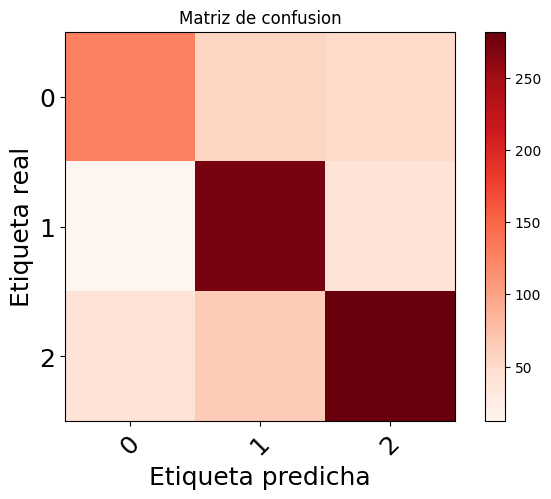

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
#Definimos las categorías que en la matriz serán 0, 1 y 2 respectivamente
categorias = ["positivo", "negativo", "neutro"]
# Graficar la matriz de confusion
plt.imshow(cm, interpolation='nearest', cmap="Reds")
plt.title("Matriz de confusion")
plt.colorbar()
tick_marks = np.arange(len(categorias))
categorias = list(range(len(categorias)))
plt.xticks(tick_marks, categorias, rotation=45,fontsize=18)
plt.yticks(tick_marks, categorias,fontsize=18)
plt.tight_layout()
plt.ylabel('Etiqueta real',fontsize=18)
plt.xlabel('Etiqueta predicha',fontsize=18)

Imprimimos el reporte de rendimiento del modelo utilizando como métricas la precision, recall y f1-score.

In [ ]:
print(classification_report(y_test, y_pred,
target_names=["Positivo", "Negativo", "Neutro"]))

              precision    recall  f1-score   support

    Positivo       0.71      0.54      0.62       236
    Negativo       0.69      0.84      0.76       326
      Neutro       0.75      0.73      0.74       386

    accuracy                           0.72       948
   macro avg       0.72      0.70      0.71       948
weighted avg       0.72      0.72      0.72       948



In [ ]:
print(accuracy_score(y_test, y_pred))

0.7204641350210971


### SVM (Maquina de soporte vectorial)


Repetimos lo anterior con la máquina de soporte vectorial y con los demás modelos, obteniendo así el rendimiento de cada uno por medio del reporte.

In [ ]:
svc = SVC(kernel='sigmoid')

In [ ]:
svc.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [ ]:
y_pred = svc.predict(X_test)

Text(0.5, 9.237950974760318, 'Etiqueta predicha')

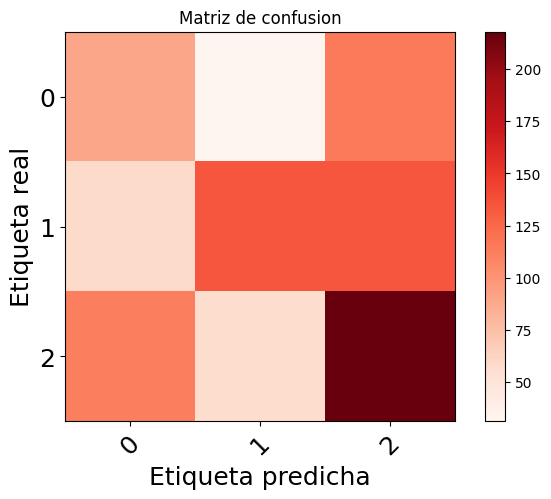

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
categorias = ["positivo", "negativo", "neutro"]
# Graficar la matriz de confusion
plt.imshow(cm, interpolation='nearest', cmap="Reds")
plt.title("Matriz de confusion")
plt.colorbar()
tick_marks = np.arange(len(categorias))
categorias = list(range(len(categorias)))
plt.xticks(tick_marks, categorias, rotation=45,fontsize=18)
plt.yticks(tick_marks, categorias,fontsize=18)
plt.tight_layout()
plt.ylabel('Etiqueta real',fontsize=18)
plt.xlabel('Etiqueta predicha',fontsize=18)

In [ ]:
print(classification_report(y_test, y_pred,
	target_names=["Positivo", "Negativo", "Neutro"]))

              precision    recall  f1-score   support

    Positivo       0.35      0.38      0.36       236
    Negativo       0.61      0.41      0.49       326
      Neutro       0.47      0.56      0.51       386

    accuracy                           0.47       948
   macro avg       0.47      0.45      0.45       948
weighted avg       0.48      0.47      0.47       948



### Random Forest

In [ ]:
RF = RandomForestClassifier(n_estimators=100, max_depth=17, random_state=42)

In [ ]:
RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, random_state=42)

In [ ]:
y_pred = RF.predict(X_test)

Text(0.5, 9.237950974760318, 'Etiqueta predicha')

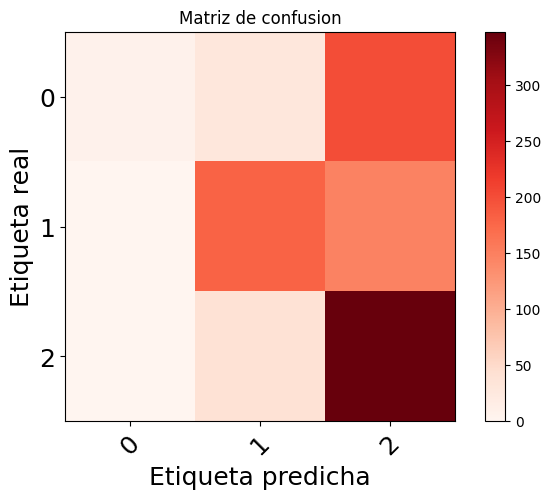

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
categorias = ["positivo", "negativo", "neutro"]
# Graficar la matriz de confusion
plt.imshow(cm, interpolation='nearest', cmap="Reds")
plt.title("Matriz de confusion")
plt.colorbar()
tick_marks = np.arange(len(categorias))
categorias = list(range(len(categorias)))
plt.xticks(tick_marks, categorias, rotation=45,fontsize=18)
plt.yticks(tick_marks, categorias,fontsize=18)
plt.tight_layout()
plt.ylabel('Etiqueta real',fontsize=18)
plt.xlabel('Etiqueta predicha',fontsize=18)

In [ ]:
print(classification_report(y_test, y_pred,
	target_names=["Positivo", "Negativo", "Neutro"]))

              precision    recall  f1-score   support

    Positivo       0.88      0.03      0.06       236
    Negativo       0.73      0.55      0.63       326
      Neutro       0.50      0.90      0.64       386

    accuracy                           0.56       948
   macro avg       0.70      0.49      0.44       948
weighted avg       0.67      0.56      0.49       948



### Naive Bayes

In [ ]:
nb = GaussianNB()

In [ ]:
nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = nb.predict(X_test)

Text(0.5, 9.237950974760318, 'Etiqueta predicha')

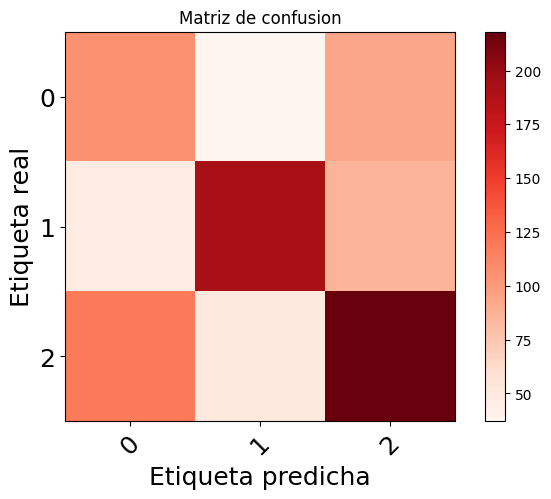

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
categorias = ["positivo", "negativo", "neutro"]
# Graficar la matriz de confusion
plt.imshow(cm, interpolation='nearest', cmap="Reds")
plt.title("Matriz de confusion")
plt.colorbar()
tick_marks = np.arange(len(categorias))
categorias = list(range(len(categorias)))
plt.xticks(tick_marks, categorias, rotation=45,fontsize=18)
plt.yticks(tick_marks, categorias,fontsize=18)
plt.tight_layout()
plt.ylabel('Etiqueta real',fontsize=18)
plt.xlabel('Etiqueta predicha',fontsize=18)

In [ ]:
print(classification_report(y_test, y_pred,
	target_names=["Positivo", "Negativo", "Neutro"]))

              precision    recall  f1-score   support

    Positivo       0.39      0.44      0.41       236
    Negativo       0.69      0.59      0.63       326
      Neutro       0.55      0.56      0.56       386

    accuracy                           0.54       948
   macro avg       0.54      0.53      0.54       948
weighted avg       0.56      0.54      0.55       948



### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

Text(0.5, 9.237950974760318, 'Etiqueta predicha')

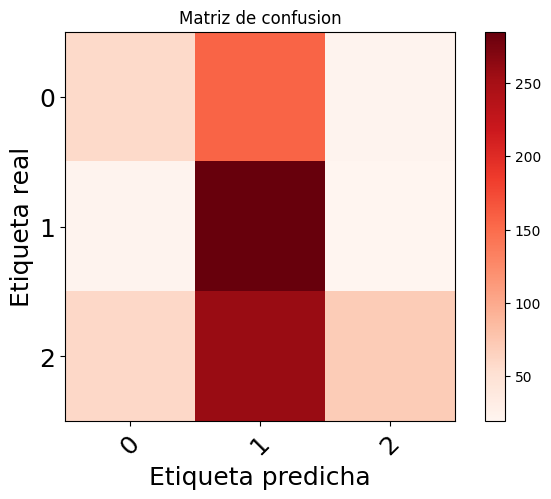

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
categorias = ["positivo", "negativo", "neutro"]
# Graficar la matriz de confusion
plt.imshow(cm, interpolation='nearest', cmap="Reds")
plt.title("Matriz de confusion")
plt.colorbar()
tick_marks = np.arange(len(categorias))
categorias = list(range(len(categorias)))
plt.xticks(tick_marks, categorias, rotation=45,fontsize=18)
plt.yticks(tick_marks, categorias,fontsize=18)
plt.tight_layout()
plt.ylabel('Etiqueta real',fontsize=18)
plt.xlabel('Etiqueta predicha',fontsize=18)

In [ ]:
print(classification_report(y_test, y_pred,
	target_names=["Positivo", "Negativo", "Neutro"]))

              precision    recall  f1-score   support

    Positivo       0.42      0.25      0.31       236
    Negativo       0.41      0.87      0.56       326
      Neutro       0.63      0.18      0.28       386

    accuracy                           0.44       948
   macro avg       0.49      0.43      0.38       948
weighted avg       0.50      0.44      0.38       948



### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

Text(0.5, 9.237950974760318, 'Etiqueta predicha')

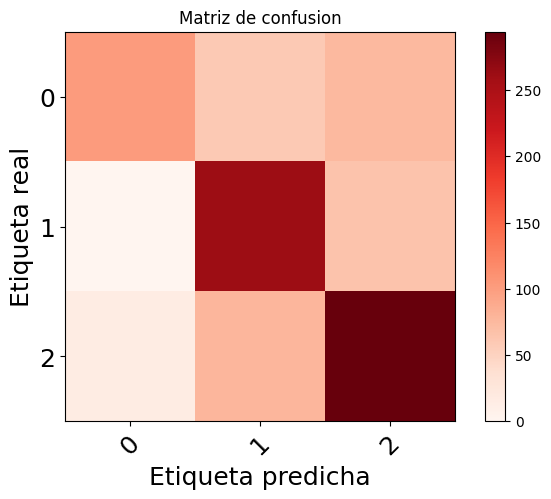

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_gb)
categorias = ["positivo", "negativo", "neutro"]
# Graficar la matriz de confusion
plt.imshow(cm, interpolation='nearest', cmap="Reds")
plt.title("Matriz de confusion")
plt.colorbar()
tick_marks = np.arange(len(categorias))
categorias = list(range(len(categorias)))
plt.xticks(tick_marks, categorias, rotation=45,fontsize=18)
plt.yticks(tick_marks, categorias,fontsize=18)
plt.tight_layout()
plt.ylabel('Etiqueta real',fontsize=18)
plt.xlabel('Etiqueta predicha',fontsize=18)

In [ ]:
print(classification_report(y_test, y_pred_gb,
	target_names=["Positivo", "Negativo", "Neutro"]))

              precision    recall  f1-score   support

    Positivo       0.87      0.43      0.58       236
    Negativo       0.66      0.80      0.72       326
      Neutro       0.68      0.76      0.72       386

    accuracy                           0.69       948
   macro avg       0.74      0.66      0.67       948
weighted avg       0.72      0.69      0.68       948



Observamos que de todos los modelos el mejor fue el de regresión logística.


![Screenshot from 2023-08-01 10-13-09.png]()


Procedemos ahora a importar el modelo.

## Exportación e importación del modelo entrenado ⏫


Exportamos el modelo con la librería pickle bajo un archivo de tipo .pkl con el nombre 'trained_model_gb.pkl'

In [ ]:
filename = 'trained_model.pkl'
pickle.dump(LR, open(filename, 'wb'))
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Con la siguiente celda, partiendo del archivo con el modelo preentrenado sea en DRIVE por ejemplo, lo importamos para hacer una predicción de un conjunto de datos.

In [ ]:
# Load model
#Path del archivo del modelo preentrando
filename_path = 'trained_model_LR_best.pkl'

pickled_model = pickle.load(open(filename_path, 'rb'))
pickled_model.predict(X_test)

#Probamos algun score
result = pickled_model.score(X_test, y_test)
print(result)


0.7204641350210971
